# Air-quality forecasting with Linear Regression and ARX

In this exercise we use simple statistical models to forecast **hourly NO₂ concentrations** based on an urban air-quality time series. The data include several years of hourly measurements (e.g. NO₂ and O₃) together with time stamps.

**Methodological goal**

- Learn how to build and evaluate **linear regression** models for time series.
- Represent **seasonal patterns** (annual, weekly, daily cycles) using **sine and cosine** terms.
- Extend the model to an **ARX model** (AutoRegressive with eXogenous input), where:
  - past values of NO₂ (lags) are used as predictors (AR part)
  - another pollutant (here O₃) is included as an external variable (X part).
- Compare different model structures (number of harmonics, lag length) using suitable error metrics.

**Application goal (air quality)**

- Quantify how well simple linear models can reproduce the **diurnal, weekly and annual cycles** of urban NO₂.
- Assess how much **forecast accuracy improves** when we:
  - include seasonal components,
  - add autoregressive terms,
  - add O₃ as an additional predictor.
- Understand how model performance varies between different **years** (e.g. 1996–1999) and what that tells us about air-quality variability.

## Task overview

Before you start coding, read through the tasks so you know where the exercise is going.

You will:

1. **Load and inspect the data**
   - Upload the air-quality dataset (hourly time series).
   - Convert the time stamp to a proper datetime and create an index `hour_idx` (hours since the beginning of the series).
   - Briefly check the time coverage and missing values.

2. **Define training and test periods**
   - Use all years **except 1999** as the **initial training set** and **1999** as the **test set**.
   - Later, repeat the evaluation using **1996**, **1997**, **1998** and **1999** each as a separate test year.

3. **Baseline and seasonal linear regression model**
   - Build a simple **baseline model** (e.g. overall mean or persistence) for NO₂ and evaluate it.
   - Construct a **linear regression model with trigonometric terms** that represent:
     - yearly cycle,
     - weekly cycle,
     - daily cycle.
   - Fit the model on the training years, predict NO₂ for the test year, and compute performance metrics (e.g. RMSE, MAE, R²).

4. **Experiment with the number of harmonics**
   - Vary the number of sine/cosine components `K` for year, week and day.
   - Study how the training and test errors change as `K` increases and discuss the results in terms of **bias–variance** (under- vs overfitting).

5. **AR and ARX modelling**
   - Extend the model with **lagged NO₂ values** to build an **AR model**.
   - Further extend it by adding lagged **O₃** as an external variable to form an **ARX model**.
   - Choose reasonable candidate lags (e.g. guided by FFT/periodogram or autocorrelation) and compare performance of different lag lengths.

6. **Model comparison and interpretation**
   - Compare:
     - baseline vs seasonal linear regression,
     - seasonal LR vs AR model,
     - AR vs ARX model (with O₃).
   - Evaluate each model for test years 1996, 1997, 1998 and 1999 and report the mean and variation of the error metrics.
   - Explain:
     - why training and test performance differ,
     - how adding seasonal terms, lags and the exogenous variable (O₃) affects the results,
     - which model you would recommend for practical NO₂ forecasting and why.

At the end of the notebook you will find more detailed guiding questions. Use them to structure your analysis and discussion.


##Linear regression

Upload the dataset

In [326]:
# With this code you can directly get access to your own disk and upload it to Google Colab
# from google.colab import files
import pandas as pd
# import io

# 1) Upload the CSV file
# uploaded = files.upload()   # Opens a file picker in Colab

# 2) Extract the filename
# fname = next(iter(uploaded))

# 3) Load CSV into a pandas DataFrame
# df = pd.read_csv(io.BytesIO(uploaded[fname]), sep=';', decimal=',')
df = pd.read_csv("AQdataNumber(AQdata) (1).csv",  sep=';', decimal=',')
# 4) Display the first rows
df.head()
# with following code you get get acees to uploded files in Google colab
#df= pd.read_csv("toolo.csv",  sep=';', decimal=',')

ID  Year  Julianday  Time   NO2    O3   PM10   CO  temperature  humidity  \
0   1  1996          1     1  77.0  11.0  23.00  1.5        -5.55      97.0   
1   2  1996          1     2  71.0  10.0  23.00  1.6        -5.55      97.0   
2   3  1996          1     3  62.0   8.0  17.33  0.8        -6.05      97.0   
3   4  1996          1     4  60.5   8.0  17.33  0.7        -6.55      97.0   
4   5  1996          1     5  59.0  10.0  17.33  0.7        -6.95      97.0   

   windspeed  sinJD  cosJD  sinTime  cosTime  
0        1.3   0.02    1.0     0.26     0.97  
1        1.3   0.02    1.0     0.50     0.87  
2        1.3   0.02    1.0     0.71     0.71  
3        1.3   0.02    1.0     0.87     0.50  
4        1.3   0.02    1.0     0.97     0.26

In [327]:
# Define standard date
df['Standard_Date'] = pd.to_datetime(
    df['Year'].astype(str) + '-' + df['Julianday'].astype(str),
    format='%Y-%j'
)
df['Standard_Date'] = df['Standard_Date'] + pd.to_timedelta(df['Time'], unit='H')
df

ID  Year  Julianday  Time    NO2     O3   PM10   CO  temperature  \
0          1  1996          1     1  77.00  11.00  23.00  1.5        -5.55   
1          2  1996          1     2  71.00  10.00  23.00  1.6        -5.55   
2          3  1996          1     3  62.00   8.00  17.33  0.8        -6.05   
3          4  1996          1     4  60.50   8.00  17.33  0.7        -6.55   
4          5  1996          1     5  59.00  10.00  17.33  0.7        -6.95   
...      ...   ...        ...   ...    ...    ...    ...  ...          ...   
35059  35060  1999        365    20  24.00  16.00  35.00  0.3       -10.35   
35060  35061  1999        365    21  27.00  12.00  63.00  0.4       -11.35   
35061  35062  1999        365    22  20.33  28.67  46.67  0.4       -12.35   
35062  35063  1999        365    23  13.67  45.33  30.33  0.4       -13.25   
35063  35064  1999        365    24   7.00  62.00  14.00  0.4       -13.25   

       humidity  windspeed  sinJD  cosJD  sinTime  cosTime       Standard_Date  
0          97.0       1.30   0.02    1.0     0.26     0.97 1996-01-01 01:00:00  
1          97.0       1.30   0.02    1.0     0.50     0.87 1996-01-01 02:00:00  
2          97.0       1.30   0.02    1.0     0.71     0.71 1996-01-01 03:00:00  
3          97.0       1.30   0.02    1.0     0.87     0.50 1996-01-01 04:00:00  
4          97.0       1.30   0.02    1.0     0.97     0.26 1996-01-01 05:00:00  
...         ...        ...    ...    ...      ...      ...                 ...  
35059      91.0       3.71   0.00    1.0    -0.87     0.50 1999-12-31 20:00:00  
35060      89.3       3.47   0.00    1.0    -0.71     0.71 1999-12-31 21:00:00  
35061      87.7       3.22   0.00    1.0    -0.50     0.87 1999-12-31 22:00:00  
35062      86.0       2.97   0.00    1.0    -0.26     0.97 1999-12-31 23:00:00  
35063      86.0       2.97   0.00    1.0     0.00     1.00 2000-01-01 00:00:00  

[35064 rows x 16 columns]

Import necassary library




In [328]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import scipy.signal as signal
import pandas as pd
import numpy as np
import re


In [329]:


import pandas as pd

# ensure it's datetime dtype
df["Standard_Date"] = pd.to_datetime(df["Standard_Date"])

# hours since the first timestamp (0, 1, 2, ...)
df["hour_idx"] = ((df["Standard_Date"] - df["Standard_Date"].min()) / pd.Timedelta(hours=1)).astype(int)
df["hour_idx"]

0            0
1            1
2            2
3            3
4            4
         ...  
35059    35059
35060    35060
35061    35061
35062    35062
35063    35063
Name: hour_idx, Length: 35064, dtype: int32

a. Split the AQdata into train and validation datasets using the last year as the validation set.

In [330]:
# Split the data to train and validation
df_data = df
df_data_train = df_data[(df_data['Year'] != 1999)].reset_index(drop = True)
df_data_test = df_data[(df_data['Year'] == 1999)].reset_index(drop = True)

set_of_features = ['hour_idx', 'NO2','O3']
df_train = df_data_train[set_of_features]
df_test = df_data_test[set_of_features]

# Calculate basic level
basic_level_train = np.mean(df_data_train, axis=0)
basic_level_test = np.mean(df_data_test, axis=0)
df_train

c:\Users\steph\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3502: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


hour_idx   NO2    O3
0             0  77.0  11.0
1             1  71.0  10.0
2             2  62.0   8.0
3             3  60.5   8.0
4             4  59.0  10.0
...         ...   ...   ...
26299     26299  10.0  52.0
26300     26300   8.0  52.0
26301     26301  11.0  51.0
26302     26302   7.0  54.0
26303     26303   6.0  53.0

[26304 rows x 3 columns]

Model the basic level, trend, and periodic components of the NO2 and O3 in the AQdata.csv using linear regression.

In [331]:
# Calculate the trend using linear models


trend_model_NO2 = LinearRegression().fit(pd.DataFrame(df_data_train['hour_idx']), pd.DataFrame(df_data_train['NO2']))
trend_model_O3 = LinearRegression().fit(pd.DataFrame(df_data_train['hour_idx']), pd.DataFrame(df_data_train['O3']))
prediction_trend_train_NO2 = trend_model_NO2.predict(pd.DataFrame(df_data_train['hour_idx'])).flatten()
prediction_trend_train_O3 = trend_model_O3.predict(pd.DataFrame(df_data_train['hour_idx'])).flatten()

In [332]:
# Data for training: NO2
df_result_train_NO2 = pd.DataFrame({'hour_idx': df_data_train['hour_idx'], 'NO2': df_data_train['NO2'],
    'basic_level': np.repeat(basic_level_train['NO2'], len(df_data_train)), 'trend': prediction_trend_train_NO2,
    'trend_residual': df_data_train['NO2'] - prediction_trend_train_NO2})
df_result_test_NO2 = pd.DataFrame({'hour_idx': df_data_test['hour_idx'], 'NO2': df_data_test['NO2']})
# Data for training: NO2
df_result_train_O3 = pd.DataFrame({'hour_idx': df_data_train['hour_idx'], 'O3': df_data_train['O3'],
    'basic_level': np.repeat(basic_level_train['O3'], len(df_data_train)), 'trend': prediction_trend_train_O3,
    'trend_residual': df_data_train['O3'] - prediction_trend_train_O3})
df_result_test_O3 = pd.DataFrame({'hour_idx': df_data_test['hour_idx'], 'O3': df_data_test['O3']})

To visualize the results, we need to create a plot. Use the following code as an example:

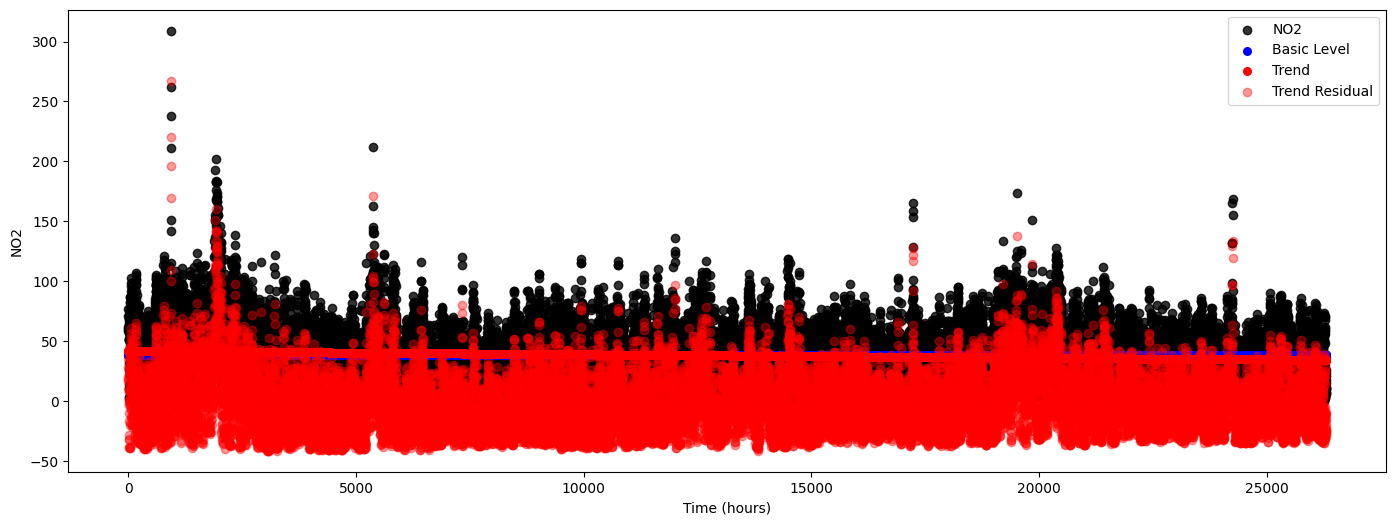

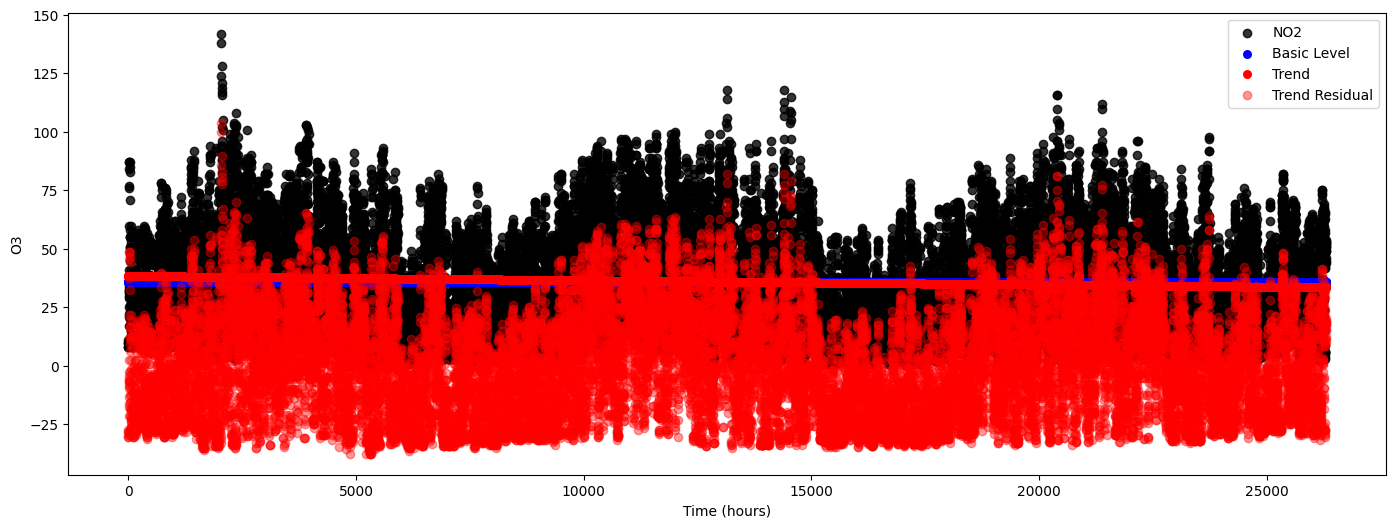

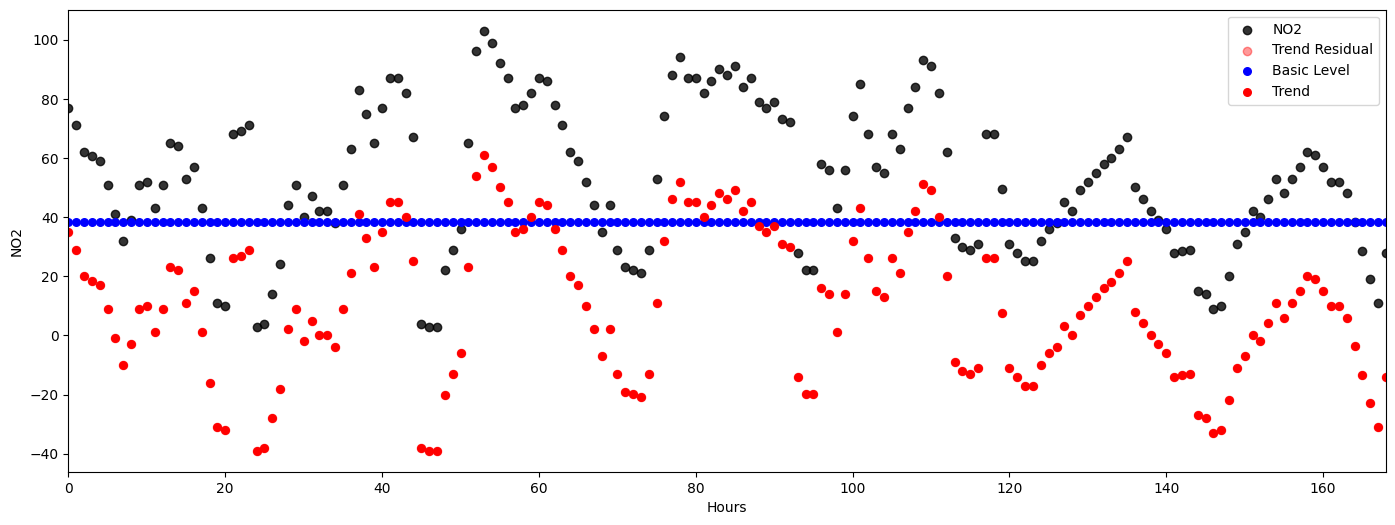

In [333]:
# Create the plot
plt.figure(figsize = (17, 6))
plt.scatter(df_result_train_NO2['hour_idx'], df_result_train_NO2['NO2'], color = 'black', alpha = 0.8, label = 'NO2')
plt.scatter(df_result_train_NO2['hour_idx'], df_result_train_NO2['basic_level'], color = 'blue', s = 30, label = 'Basic Level')
plt.scatter(df_result_train_NO2['hour_idx'], df_result_train_NO2['trend'], color = 'red', s = 30, label = 'Trend')
plt.scatter(df_result_train_NO2['hour_idx'], df_result_train_NO2['trend_residual'], color = 'red', alpha = 0.4, label = 'Trend Residual')
plt.xlabel('Time (hours)')
plt.ylabel('NO2')
plt.legend()
plt.show()
# Create the plot
plt.figure(figsize = (17, 6))
plt.scatter(df_result_train_NO2['hour_idx'], df_result_train_O3['O3'], color = 'black', alpha = 0.8, label = 'NO2')
plt.scatter(df_result_train_NO2['hour_idx'], df_result_train_O3['basic_level'], color = 'blue', s = 30, label = 'Basic Level')
plt.scatter(df_result_train_NO2['hour_idx'], df_result_train_O3['trend'], color = 'red', s = 30, label = 'Trend')
plt.scatter(df_result_train_NO2['hour_idx'], df_result_train_O3['trend_residual'], color = 'red', alpha = 0.4, label = 'Trend Residual')
plt.xlabel('Time (hours)')
plt.ylabel('O3')
plt.legend()
plt.show()
#----

# choose a window on the x-axis to zoom into
xmin, xmax = 0, 168   # <- set to the range you want

mask = (df_result_train_NO2["hour_idx"] >= xmin) & (df_result_train_NO2["hour_idx"] <= xmax)
df_zoom = df_result_train_NO2.loc[mask]

plt.figure(figsize=(17, 6))
plt.scatter(df_zoom["hour_idx"], df_zoom["NO2"], color = 'black', alpha = 0.8, label = 'NO2')
plt.scatter(df_zoom["hour_idx"], df_zoom['trend_residual'], color = 'red', alpha = 0.4, label = 'Trend Residual')
plt.scatter(df_zoom["hour_idx"], df_zoom['basic_level'], color = 'blue', s = 30, label = 'Basic Level')
plt.scatter(df_zoom["hour_idx"], df_zoom['trend_residual'], color = 'red', s = 30, label = 'Trend')
plt.xlim(xmin, xmax)
plt.xlabel("Hours"); plt.ylabel("NO2"); plt.legend(); plt.show()

Here we plot the observation data, its mean value, trend, and residuals for the trend.

To build a static model that is based on the trigonometric decomposition of the observations, we would need the following functions:

In [334]:
def make_trigonometric_matrix(number_of_freqs, w0, x):
    df_trigonometric_lm = pd.DataFrame()

    for k in range(1, number_of_freqs + 1):
        df_trigonometric_lm[f"sin_{k}"] = np.sin(k * w0 * x)
        df_trigonometric_lm[f"cos_{k}"] = np.cos(k * w0 * x)

    return df_trigonometric_lm

def make_trigonometric_lm(number_of_freqs, w0, x, y):
    df_trigonometric_lm = make_trigonometric_matrix(number_of_freqs, w0, x)
    df_trigonometric_lm["y"] = y

    trig_regression = LinearRegression().fit(df_trigonometric_lm.drop("y", axis=1), df_trigonometric_lm["y"])
    return trig_regression


Now we can make linear models for year, week, and day.

In [335]:
# Year
year_w0 = (2 * np.pi) / (365 * 24)
year_number_of_components = 24  # <-- adjust K_year here
year_trigonometric_lm = make_trigonometric_lm(
    number_of_freqs = year_number_of_components,
    w0 = year_w0,
    x = df_result_train_NO2["hour_idx"],
    y = df_result_train_NO2["trend_residual"]
)
year_model = year_trigonometric_lm

X = make_trigonometric_matrix(year_number_of_components, year_w0, df_result_train_NO2["hour_idx"])

year_prediction = year_trigonometric_lm.predict(X)
year_residual = df_result_train_NO2["trend_residual"] - year_trigonometric_lm.predict(X)


In [336]:
# Week
week_w0 = (2 * np.pi) / (7 * 24)
week_number_of_components = 24   # <-- adjust K_week here
week_trigonometric_lm = make_trigonometric_lm(
    number_of_freqs = week_number_of_components,
    w0 = week_w0,
    x = df_result_train_NO2["hour_idx"],
    y = year_residual
)
week_model = week_trigonometric_lm
X = make_trigonometric_matrix(week_number_of_components, week_w0, df_result_train_NO2["hour_idx"])
week_prediction = week_trigonometric_lm.predict(X)
week_residual = df_result_train_NO2["trend_residual"] - week_trigonometric_lm.predict(X)


In [337]:
# Day
day_w0 = (2 * np.pi) / (1 * 24)
day_number_of_components = 12 # <-- adjust K_day here
day_trigonometric_lm = make_trigonometric_lm(number_of_freqs = day_number_of_components,
    w0 = day_w0,
    x = df_result_train_NO2["hour_idx"],
    y = week_residual)
day_model = day_trigonometric_lm
X = make_trigonometric_matrix(day_number_of_components, week_w0, df_result_train_NO2["hour_idx"])

day_prediction = day_trigonometric_lm.predict(X)


In [338]:
# Final model
final_prediction = df_result_train_NO2['trend'] + year_prediction + week_prediction + day_prediction
final_residual = df_result_train_NO2['NO2'] - final_prediction

# Add columns to the DataFrame
df_result_train_NO2['final_prediction'] = final_prediction
df_result_train_NO2['final_residuals'] = final_residual


In [339]:
def calc_r_squared(predicted, observed):
    rss = sum((predicted - observed) ** 2)
    tss = sum((observed - np.mean(observed)) ** 2)
    r_squared = 1 - rss / tss
    return r_squared

def index_agreement (s, o):
    ia = 1 - (np.sum((o-s)**2)) / (np.sum((np.abs(s - np.mean(o)) + np.abs(o - np.mean(o))) ** 2))
    return ia

def calc_rmse(predicted, observed):
    rmse = np.sqrt(np.mean((predicted - observed) ** 2))
    return rmse

def calc_pse(predicted, observed):
    rmse = calc_rmse(predicted, observed)
    lm_residual = np.polyval(np.polyfit(observed, predicted, 1), observed)
    lm_rmse = calc_rmse(lm_residual, observed)
    pse = (lm_rmse ** 2) / (rmse ** 2)
    return pse

In [340]:
# === Build components for TRAIN & TEST ===

# 1) Trend
x_tr  = df_result_train_NO2["hour_idx"].values
x_te  = df_result_test_NO2["hour_idx"].values
y_tr  = df_result_train_NO2["NO2"].values
y_te  = df_result_test_NO2["NO2"].values

trend_tr = trend_model_NO2.predict(x_tr.reshape(-1, 1)).flatten()
trend_te = trend_model_NO2.predict(x_te.reshape(-1, 1)).flatten()

# Detrended series
detr_tr = y_tr - trend_tr
detr_te = y_te - trend_te

# 2) Yearly component
X_year_tr = make_trigonometric_matrix(year_number_of_components, year_w0, x_tr)
X_year_te = make_trigonometric_matrix(year_number_of_components, year_w0, x_te)
year_tr   = year_model.predict(X_year_tr)
year_te   = year_model.predict(X_year_te)

resid_after_year_tr = detr_tr - year_tr
resid_after_year_te = detr_te - year_te

# 3) Weekly component
X_week_tr = make_trigonometric_matrix(week_number_of_components, week_w0, x_tr)
X_week_te = make_trigonometric_matrix(week_number_of_components, week_w0, x_te)
week_tr   = week_model.predict(X_week_tr)
week_te   = week_model.predict(X_week_te)

resid_after_week_tr = resid_after_year_tr - week_tr
resid_after_week_te = resid_after_year_te - week_te

# 4) Daily component
X_day_tr = make_trigonometric_matrix(day_number_of_components, day_w0, x_tr)
X_day_te = make_trigonometric_matrix(day_number_of_components, day_w0, x_te)
day_tr   = day_model.predict(X_day_tr)
day_te   = day_model.predict(X_day_te)

resid_after_day_tr = resid_after_week_tr - day_tr
resid_after_day_te = resid_after_week_te - day_te

# 5) Combined fit: Trend + Year + Week + Day
combined_tr = trend_tr + year_tr + week_tr + day_tr
combined_te = trend_te + year_te + week_te + day_te

# === Metrics (IA & R2) for each stage ===
def stage_metrics(pred, obs):
    return (
        index_agreement(pred, obs),
        calc_r_squared(pred, obs)
    )

# TRAIN
ia_tr_trend,   r2_tr_trend   = stage_metrics(trend_tr, y_tr)
ia_tr_year,    r2_tr_year    = stage_metrics(year_tr, detr_tr)
ia_tr_week,    r2_tr_week    = stage_metrics(week_tr, resid_after_year_tr)
ia_tr_day,     r2_tr_day     = stage_metrics(day_tr, resid_after_week_tr)
ia_tr_comb,    r2_tr_comb    = stage_metrics(combined_tr, y_tr)

# TEST
ia_te_trend,   r2_te_trend   = stage_metrics(trend_te, y_te)
ia_te_year,    r2_te_year    = stage_metrics(year_te, detr_te)
ia_te_week,    r2_te_week    = stage_metrics(week_te, resid_after_year_te)
ia_te_day,     r2_te_day     = stage_metrics(day_te, resid_after_week_te)
ia_te_comb,    r2_te_comb    = stage_metrics(combined_te, y_te)


c:\Users\steph\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\steph\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


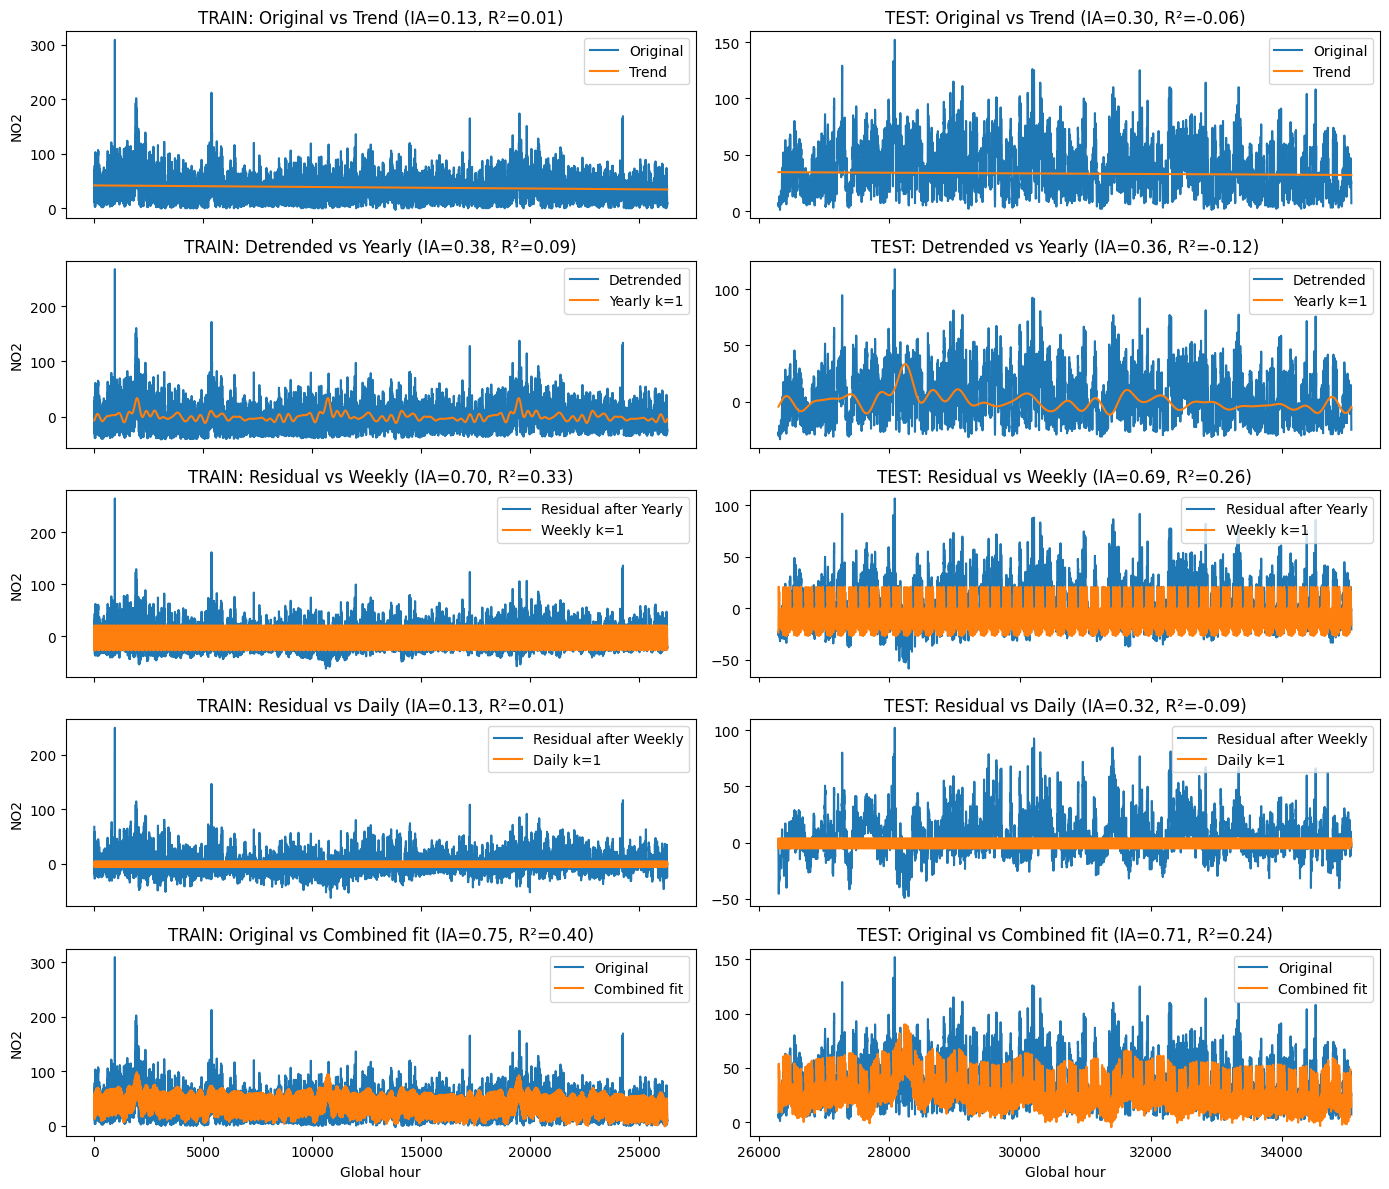

In [341]:
fig, axes = plt.subplots(5, 2, figsize=(14, 12), sharex='col')
(ax_tr0, ax_te0), (ax_tr1, ax_te1), (ax_tr2, ax_te2), (ax_tr3, ax_te3), (ax_tr4, ax_te4) = axes

# 1) Original vs Trend
ax_tr0.plot(x_tr, y_tr, label="Original")
ax_tr0.plot(x_tr, trend_tr, label="Trend")
ax_tr0.set_title(f"TRAIN: Original vs Trend (IA={ia_tr_trend:.2f}, R²={r2_tr_trend:.2f})")
ax_tr0.set_ylabel("NO2")
ax_tr0.legend()

ax_te0.plot(x_te, y_te, label="Original")
ax_te0.plot(x_te, trend_te, label="Trend")
ax_te0.set_title(f"TEST: Original vs Trend (IA={ia_te_trend:.2f}, R²={r2_te_trend:.2f})")
ax_te0.legend()

# 2) Detrended vs Yearly
ax_tr1.plot(x_tr, detr_tr, label="Detrended")
ax_tr1.plot(x_tr, year_tr, label="Yearly k=1")
ax_tr1.set_title(f"TRAIN: Detrended vs Yearly (IA={ia_tr_year:.2f}, R²={r2_tr_year:.2f})")
ax_tr1.set_ylabel("NO2")
ax_tr1.legend()

ax_te1.plot(x_te, detr_te, label="Detrended")
ax_te1.plot(x_te, year_te, label="Yearly k=1")
ax_te1.set_title(f"TEST: Detrended vs Yearly (IA={ia_te_year:.2f}, R²={r2_te_year:.2f})")
ax_te1.legend()

# 3) Residual vs Weekly
ax_tr2.plot(x_tr, resid_after_year_tr, label="Residual after Yearly")
ax_tr2.plot(x_tr, week_tr, label="Weekly k=1")
ax_tr2.set_title(f"TRAIN: Residual vs Weekly (IA={ia_tr_week:.2f}, R²={r2_tr_week:.2f})")
ax_tr2.set_ylabel("NO2")
ax_tr2.legend()

ax_te2.plot(x_te, resid_after_year_te, label="Residual after Yearly")
ax_te2.plot(x_te, week_te, label="Weekly k=1")
ax_te2.set_title(f"TEST: Residual vs Weekly (IA={ia_te_week:.2f}, R²={r2_te_week:.2f})")
ax_te2.legend()

# 4) Residual vs Daily
ax_tr3.plot(x_tr, resid_after_week_tr, label="Residual after Weekly")
ax_tr3.plot(x_tr, day_tr, label="Daily k=1")
ax_tr3.set_title(f"TRAIN: Residual vs Daily (IA={ia_tr_day:.2f}, R²={r2_tr_day:.2f})")
ax_tr3.set_ylabel("NO2")
ax_tr3.legend()

ax_te3.plot(x_te, resid_after_week_te, label="Residual after Weekly")
ax_te3.plot(x_te, day_te, label="Daily k=1")
ax_te3.set_title(f"TEST: Residual vs Daily (IA={ia_te_day:.2f}, R²={r2_te_day:.2f})")
ax_te3.legend()

# 5) Original vs Combined fit
ax_tr4.plot(x_tr, y_tr, label="Original")
ax_tr4.plot(x_tr, combined_tr, label="Combined fit")
ax_tr4.set_title(f"TRAIN: Original vs Combined fit (IA={ia_tr_comb:.2f}, R²={r2_tr_comb:.2f})")
ax_tr4.set_xlabel("Global hour")
ax_tr4.set_ylabel("NO2")
ax_tr4.legend()

ax_te4.plot(x_te, y_te, label="Original")
ax_te4.plot(x_te, combined_te, label="Combined fit")
ax_te4.set_title(f"TEST: Original vs Combined fit (IA={ia_te_comb:.2f}, R²={r2_te_comb:.2f})")
ax_te4.set_xlabel("Global hour")
ax_te4.legend()

plt.tight_layout()
plt.show()


So, it is possible to visualize the data and see how good the predictions are.

##Please ignore this cell.

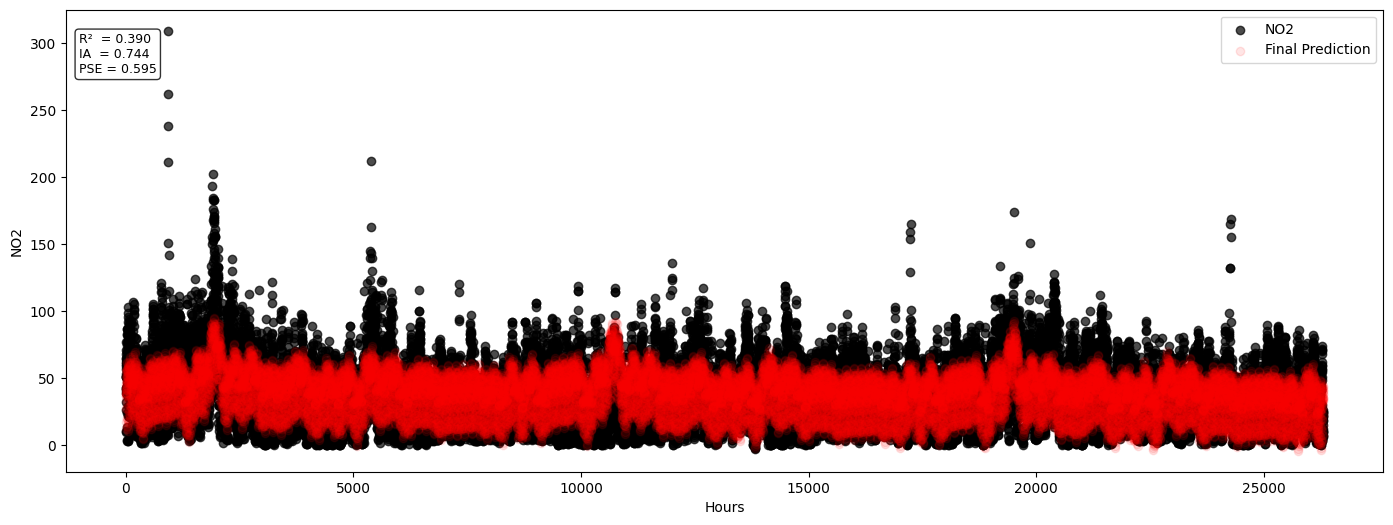

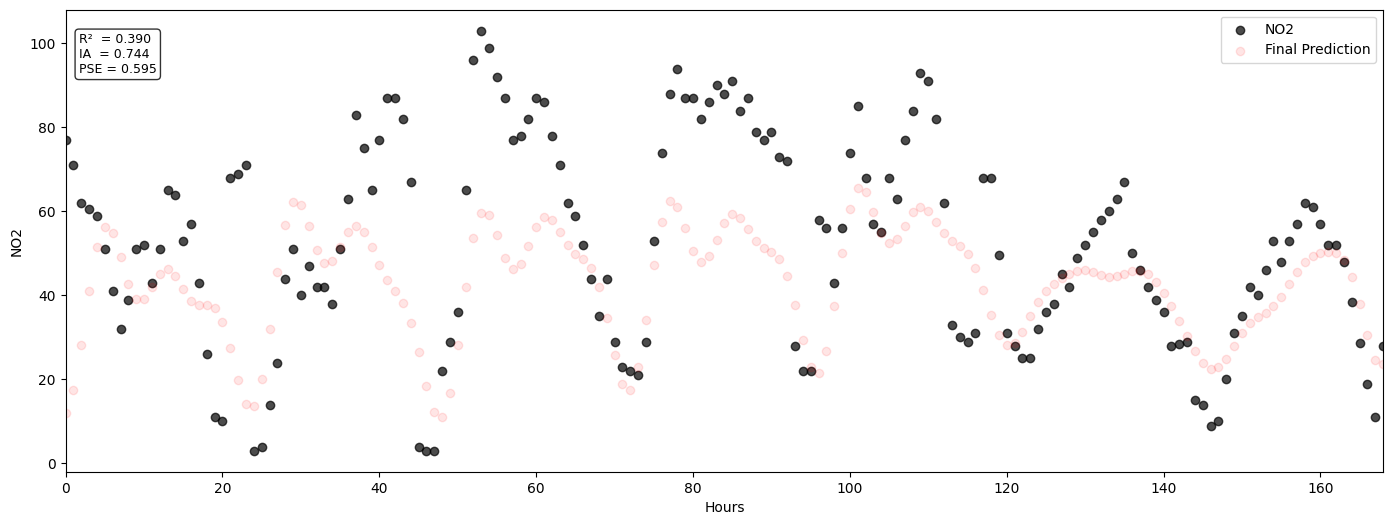

In [342]:
def calc_r_squared(predicted, observed):
    rss = sum((predicted - observed) ** 2)
    tss = sum((observed - np.mean(observed)) ** 2)
    r_squared = 1 - rss / tss
    return r_squared

def index_agreement (s, o):
    ia = 1 - (np.sum((o-s)**2)) / (np.sum((np.abs(s - np.mean(o)) + np.abs(o - np.mean(o))) ** 2))
    return ia

def calc_rmse(predicted, observed):
    rmse = np.sqrt(np.mean((predicted - observed) ** 2))
    return rmse

def calc_pse(predicted, observed):
    rmse = calc_rmse(predicted, observed)
    lm_residual = np.polyval(np.polyfit(observed, predicted, 1), observed)
    lm_rmse = calc_rmse(lm_residual, observed)
    pse = (lm_rmse ** 2) / (rmse ** 2)
    return pse

# ---- compute metrics once for this dataset ----
y_true = df_result_train_NO2["NO2"].values
y_pred = df_result_train_NO2["final_prediction"].values

r2_train  = calc_r_squared(y_pred, y_true)
ia_train  = index_agreement(y_pred, y_true)
pse_train = calc_pse(y_pred, y_true)

textstr_train = (
    f"R²  = {r2_train:.3f}\n"
    f"IA  = {ia_train:.3f}\n"
    f"PSE = {pse_train:.3f}"
)

# ================== FULL TRAIN PLOT ==================
plt.figure(figsize=(17, 6))
plt.scatter(df_result_train_NO2['hour_idx'], df_result_train_NO2['NO2'],
            color='black', alpha=0.7, label='NO2')
plt.scatter(df_result_train_NO2['hour_idx'], df_result_train_NO2['final_prediction'],
            color='red', alpha=0.1, label='Final Prediction')
plt.xlabel('Hours')
plt.ylabel('NO2')
plt.legend(loc="upper right")

# metrics box
ax = plt.gca()
ax.text(
    0.01, 0.95,
    textstr_train,
    transform=ax.transAxes,
    va="top",
    ha="left",
    fontsize=9,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
)

plt.show()

# ================== ZOOMED TRAIN PLOT ==================
# choose a window on the x-axis to zoom into
xmin, xmax = 0, 168   # <- set to the range you want

mask = (df_result_train_NO2["hour_idx"] >= xmin) & (df_result_train_NO2["hour_idx"] <= xmax)
df_zoom = df_result_train_NO2.loc[mask]

plt.figure(figsize=(17, 6))
plt.scatter(df_zoom["hour_idx"], df_zoom["NO2"],
            color='black', alpha=0.7, label='NO2')
plt.scatter(df_zoom["hour_idx"], df_zoom['final_prediction'],
            color='red', alpha=0.1, label='Final Prediction')

plt.xlim(xmin, xmax)
plt.xlabel("Hours")
plt.ylabel("NO2")
plt.legend(loc="upper right")

# reuse same TRAIN metrics box
ax = plt.gca()
ax.text(
    0.01, 0.95,
    textstr_train,
    transform=ax.transAxes,
    va="top",
    ha="left",
    fontsize=9,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
)

plt.show()

To examine how the model fits the test data we need to make a prediction for it. Since that involves different trigonometric models, we performed another specific function that uses the previously identified models to perform that prediction:

In [343]:
def make_prediction(x, year_w0, week_w0, day_w0, year_number_of_components, week_number_of_components, day_number_of_components, trend_model, year_model, week_model, day_model):
    # Trend prediction
    # Make inputs for year
    year = make_trigonometric_matrix(number_of_freqs = year_number_of_components, w0 = year_w0, x = x)
    # Make prediction for year trigonometric model
    year_prediction = year_model.predict(year)

    # Make inputs for week
    week = make_trigonometric_matrix(number_of_freqs = week_number_of_components, w0 = week_w0, x = x)
    # Make prediction for week trigonometric model
    week_prediction = week_model.predict(week)

    # Make inputs for day
    day = make_trigonometric_matrix(number_of_freqs = day_number_of_components, w0 = day_w0, x = x)
    # Make prediction for day trigonometric model
    day_prediction = day_model.predict(day)


    trend_prediction = trend_model.predict(x).flatten()

    return year_prediction + week_prediction + day_prediction + trend_prediction


In [344]:
prediction_data = make_prediction(
    x = pd.DataFrame(df_data_test['hour_idx']),
    year_w0 = year_w0,
    week_w0 = week_w0,
    day_w0 = day_w0,
    year_number_of_components = year_number_of_components,
    week_number_of_components = week_number_of_components,
    day_number_of_components = day_number_of_components,

    trend_model = trend_model_NO2,
    year_model = year_model,
    week_model = week_model,
    day_model = day_model
)

df_result_test_NO2 = pd.DataFrame({
    "hour_idx": df_test["hour_idx"], # Include hour_idx here
    "NO2": df_test["NO2"]
})
df_result_test_NO2["final_prediction"] = prediction_data
df_result_test_NO2["final_residuals"] = df_test["NO2"] - prediction_data

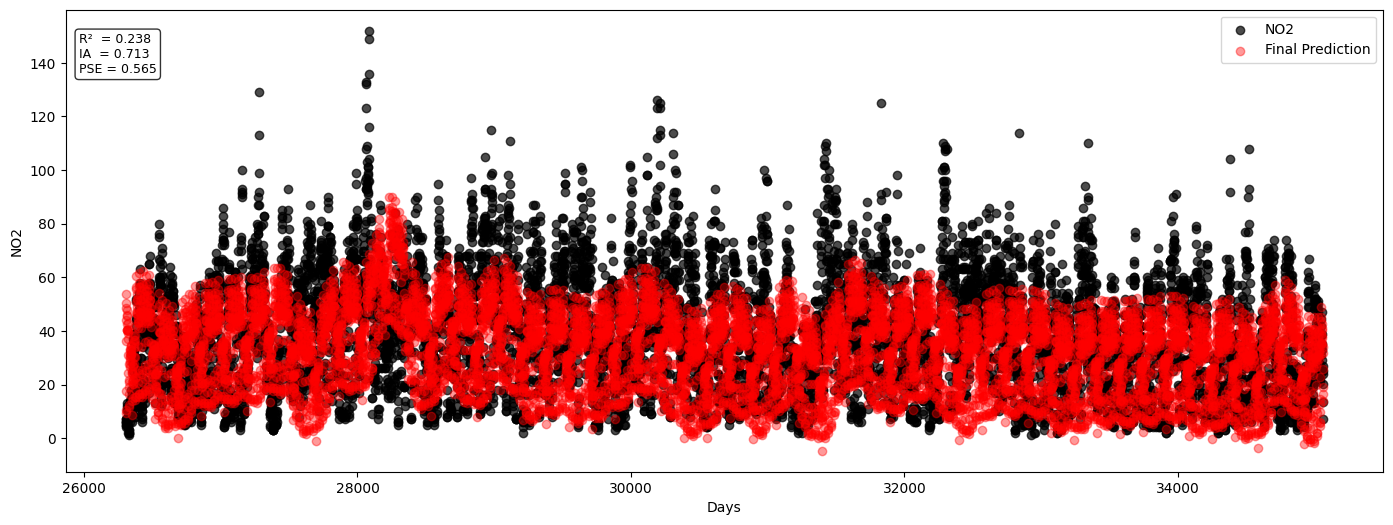

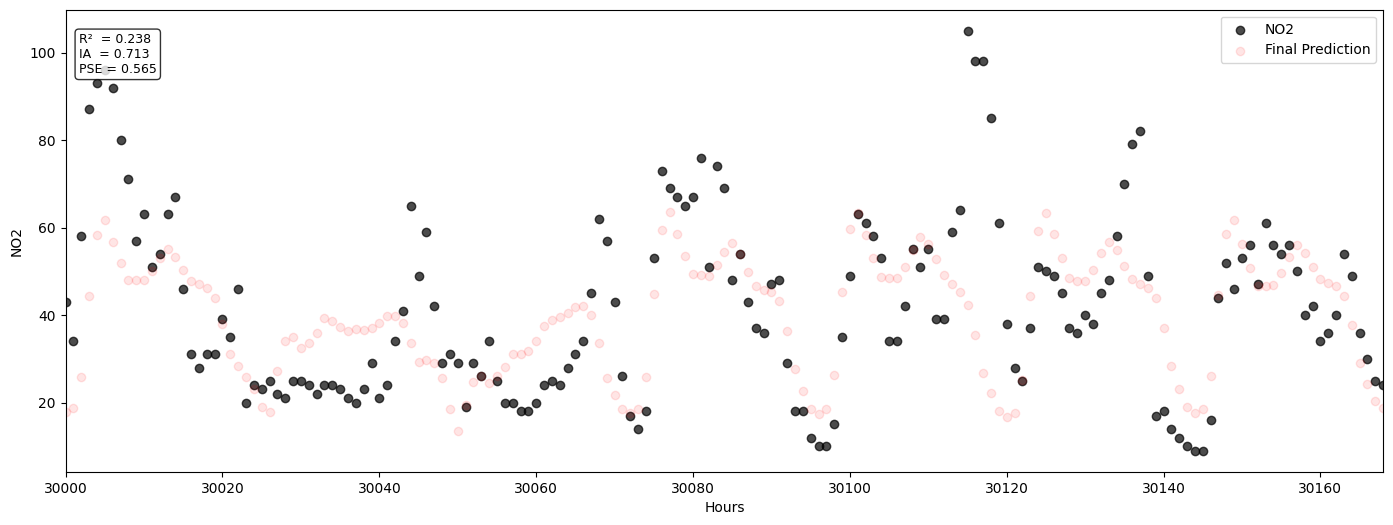

In [345]:
# ---- compute metrics once for TEST dataset ----
y_true_test = df_result_test_NO2["NO2"].values
y_pred_test = df_result_test_NO2["final_prediction"].values

r2_test  = calc_r_squared(y_pred_test, y_true_test)
ia_test  = index_agreement(y_pred_test, y_true_test)
pse_test = calc_pse(y_pred_test, y_true_test)

textstr_test = (
    f"R²  = {r2_test:.3f}\n"
    f"IA  = {ia_test:.3f}\n"
    f"PSE = {pse_test:.3f}"
)

# ================== FULL TEST PLOT ==================
plt.figure(figsize=(17, 6))
plt.scatter(df_result_test_NO2["hour_idx"], df_result_test_NO2["NO2"],
            color="black", alpha=0.7, label="NO2")
plt.scatter(df_result_test_NO2["hour_idx"], df_result_test_NO2["final_prediction"],
            color="red", alpha=0.4, label="Final Prediction")
plt.xlabel("Days")
plt.ylabel("NO2")
plt.legend(loc="upper right")

ax = plt.gca()
ax.text(
    0.01, 0.95,
    textstr_test,
    transform=ax.transAxes,
    va="top",
    ha="left",
    fontsize=9,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
)

plt.show()

# ================== ZOOMED TEST PLOT ==================
# choose a window on the x-axis to zoom into
xmin, xmax = 30000, 30168   # <- set to the range you want

mask = (df_result_test_NO2["hour_idx"] >= xmin) & (df_result_test_NO2["hour_idx"] <= xmax)
df_zoom = df_result_test_NO2.loc[mask]

plt.figure(figsize=(17, 6))
plt.scatter(df_zoom["hour_idx"], df_zoom["NO2"],
            color="black", alpha=0.7, label="NO2")
plt.scatter(df_zoom["hour_idx"], df_zoom["final_prediction"],
            color="red", alpha=0.1, label="Final Prediction")

plt.xlim(xmin, xmax)
plt.xlabel("Hours")
plt.ylabel("NO2")
plt.legend(loc="upper right")

ax = plt.gca()
ax.text(
    0.01, 0.95,
    textstr_test,
    transform=ax.transAxes,
    va="top",
    ha="left",
    fontsize=9,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
)

plt.show()


To estimate the quality of the model, we can define several functions, such as R squared, RMSE, index of agreements, and proportional systematic error statistics, which are implemented below.

In [346]:
def calc_r_squared(predicted, observed):
    rss = sum((predicted - observed) ** 2)
    tss = sum((observed - np.mean(observed)) ** 2)
    r_squared = 1 - rss / tss
    return r_squared

def index_agreement (s, o):
    ia = 1 - (np.sum((o-s)**2)) / (np.sum((np.abs(s - np.mean(o)) + np.abs(o - np.mean(o))) ** 2))
    return ia

def calc_rmse(predicted, observed):
    rmse = np.sqrt(np.mean((predicted - observed) ** 2))
    return rmse

def calc_pse(predicted, observed):
    rmse = calc_rmse(predicted, observed)
    lm_residual = np.polyval(np.polyfit(observed, predicted, 1), observed)
    lm_rmse = calc_rmse(lm_residual, observed)
    pse = (lm_rmse ** 2) / (rmse ** 2)
    return pse


In [347]:
# Calculate statistics for train data, NO2
train_NO2_r_squared = calc_r_squared(df_result_train_NO2["final_prediction"], df_result_train_NO2["NO2"])
train_NO2_ia = index_agreement(df_result_train_NO2["final_prediction"], df_result_train_NO2["NO2"])
train_NO2_rmse = calc_rmse(df_result_train_NO2["final_prediction"], df_result_train_NO2["NO2"])
train_NO2_pse = calc_pse(df_result_train_NO2["final_prediction"], df_result_train_NO2["NO2"])

print("------------------------------------------------------")
print("Statistics for train data, NO2:")
print(f"R squared: {train_NO2_r_squared}")
print(f"Index of agreement: {train_NO2_ia}")
print(f"RMSE: {train_NO2_rmse}")
print(f"Proportion of systematic error: {train_NO2_pse}")

# Calculate statistics for test data, NO2
test_NO2_r_squared = calc_r_squared(df_result_test_NO2["final_prediction"], df_result_test_NO2["NO2"])
test_NO2_ia = index_agreement(df_result_test_NO2["final_prediction"], df_result_test_NO2["NO2"])
test_NO2_rmse = calc_rmse(df_result_test_NO2["final_prediction"], df_result_test_NO2["NO2"])
test_NO2_pse = calc_pse(df_result_test_NO2["final_prediction"], df_result_test_NO2["NO2"])

print("------------------------------------------------------")
print("Statistics for test data, NO2:")
print(f"R squared: {test_NO2_r_squared}")
print(f"Index of agreement: {test_NO2_ia}")
print(f"RMSE: {test_NO2_rmse}")
print(f"Proportion of systematic error: {test_NO2_pse}")


------------------------------------------------------
Statistics for train data, NO2:
R squared: 0.39008756744987527
Index of agreement: 0.7438640792362345
RMSE: 18.535186107195653
Proportion of systematic error: 0.5954592129325281
------------------------------------------------------
Statistics for test data, NO2:
R squared: 0.23797864240588362
Index of agreement: 0.7127653601016785
RMSE: 18.756952665688488
Proportion of systematic error: 0.5646010976253577


Question:


Use 1996, 1997, and 1998 as separate test periods (three runs). Also evaluate with 1999 as the test period.
Report the mean performance across 1996-1998 and explain why different test periods lead to different model performance based on the metrics.


Explain the reasons for differences between training and test performance


Change K  for the year, week, and day components (e.g., small/medium/large values). Analyze how performance changes as K changes, and explain the results in terms of bias-variance.

Task 3. AR(X) modeling
In order to form a 12-hours prediction value of the NO2 – concentration of the AQdata construct (optimize the models by finding suitable lags for the models):
a. AR – model
b. ARX – model, in which O3 is the external variable

Task 3. Guide
To make AR and ARX models we make data preprocessing and add some lags of the output observations (NO2) and input observations (O3):


In [348]:
lags_number = 168

# Copy the data to work with lags
df_train_lagged = df_train.copy()
df_test_lagged = df_test.copy()

# Add the lagged data to the table
for i_lag in range(24, 24 + lags_number + 1):
    # Add lag for no2 train
    df_train_lagged[f"NO2_lag_{i_lag}"] = df_train_lagged["NO2"].shift(i_lag)

    # Add lag for o3 train
    df_train_lagged[f"O3_lag_{i_lag}"] = df_train_lagged["O3"].shift(i_lag)

    # Add lag for no2 test
    df_test_lagged[f"NO2_lag_{i_lag}"] = df_test_lagged["NO2"].shift(i_lag)

    # Add lag for o3 test
    df_test_lagged[f"O3_lag_{i_lag}"] = df_test_lagged["O3"].shift(i_lag)


C:\Users\steph\AppData\Local\Temp\ipykernel_20672\533878914.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train_lagged[f"NO2_lag_{i_lag}"] = df_train_lagged["NO2"].shift(i_lag)
C:\Users\steph\AppData\Local\Temp\ipykernel_20672\533878914.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train_lagged[f"O3_lag_{i_lag}"] = df_train_lagged["O3"].shift(i_lag)
C:\Users\steph\AppData\Local\Temp\ipykernel_20672\533878914.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fra

As the next step, we filter out the variables we need and omit the missing data, which is a result of adding the lagged observations.

In [349]:
# Get variable names for lags
current_colnames = df_train_lagged.columns
lag_names_NO2 = [col for col in current_colnames if re.search(r"NO2_lag", col)]
lag_names_O3 = [col for col in current_colnames if re.search(r"O3_lag", col)]

# Train datasets
df_train_lagged_NO2 = df_train_lagged.filter(like = "NO2").dropna()
df_train_lagged_NO2_and_O3 = df_train_lagged.filter(regex="NO2|O3_lag").dropna()

# Test datasets
df_test_lagged_NO2 = df_test_lagged.filter(like = "NO2").dropna()
df_test_lagged_NO2_and_O3 = df_test_lagged.filter(regex="NO2|O3_lag").dropna()


Here we build the AR model for the data frame df_train_lagged_NO2 and ARX model for the data frame df_train_lagged_NO2_and_O3

In [350]:
# Models
lm_NO2 = LinearRegression().fit(df_train_lagged_NO2.drop(columns = ["NO2"]), df_train_lagged_NO2["NO2"])
lm_NO2_on_NO2_and_O3 = LinearRegression().fit(df_train_lagged_NO2_and_O3.drop(columns = ["NO2"]), df_train_lagged_NO2_and_O3["NO2"])

# Add predictions to dataframe
df_train_lagged = df_train_lagged.dropna()
df_train_lagged["prediction_NO2"] = lm_NO2.predict(df_train_lagged_NO2.drop(columns = ["NO2"]))
df_train_lagged["prediction_NO2_O3"] = lm_NO2_on_NO2_and_O3.predict(df_train_lagged_NO2_and_O3.drop(columns=["NO2"]))


Then we apply these models to the test data:

In [351]:
# Test prediction
test_prediction_NO2 = lm_NO2.predict(df_test_lagged_NO2.drop(columns = ["NO2"]))
test_prediction_NO2_O3 = lm_NO2_on_NO2_and_O3.predict(df_test_lagged_NO2_and_O3.drop(columns = ["NO2"]))

# Add predictions on test to dataframe
df_test_lagged = df_test_lagged.dropna()
df_test_lagged["prediction_NO2"] = test_prediction_NO2
df_test_lagged["prediction_NO2_O3"] = test_prediction_NO2_O3


Now we can make plots to see the results:

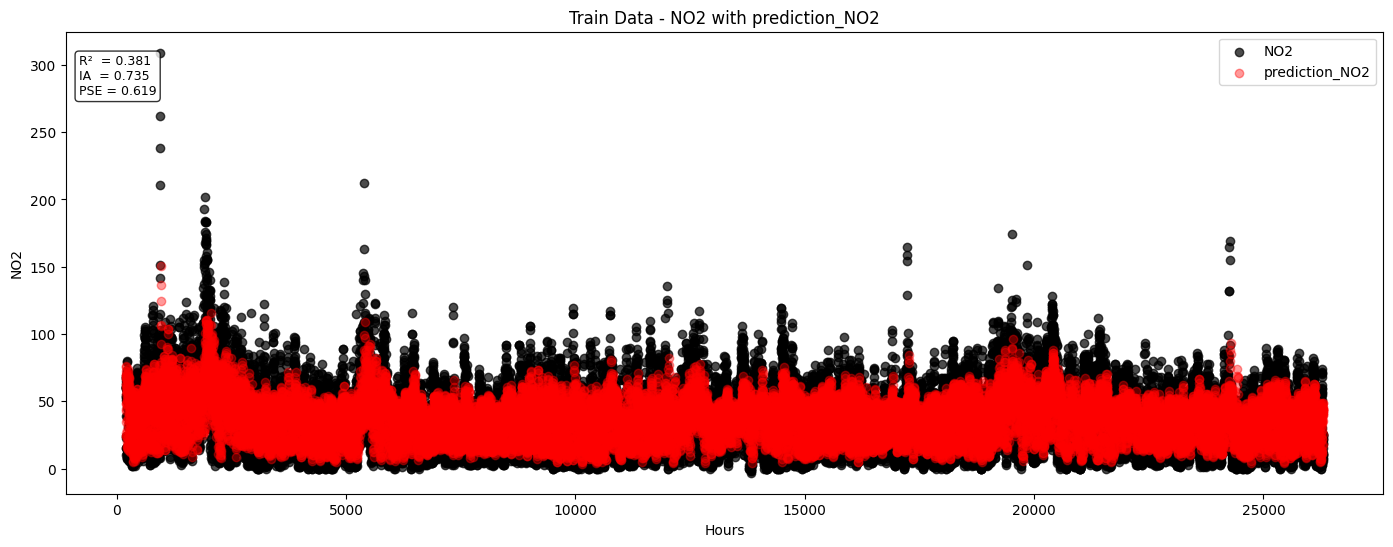

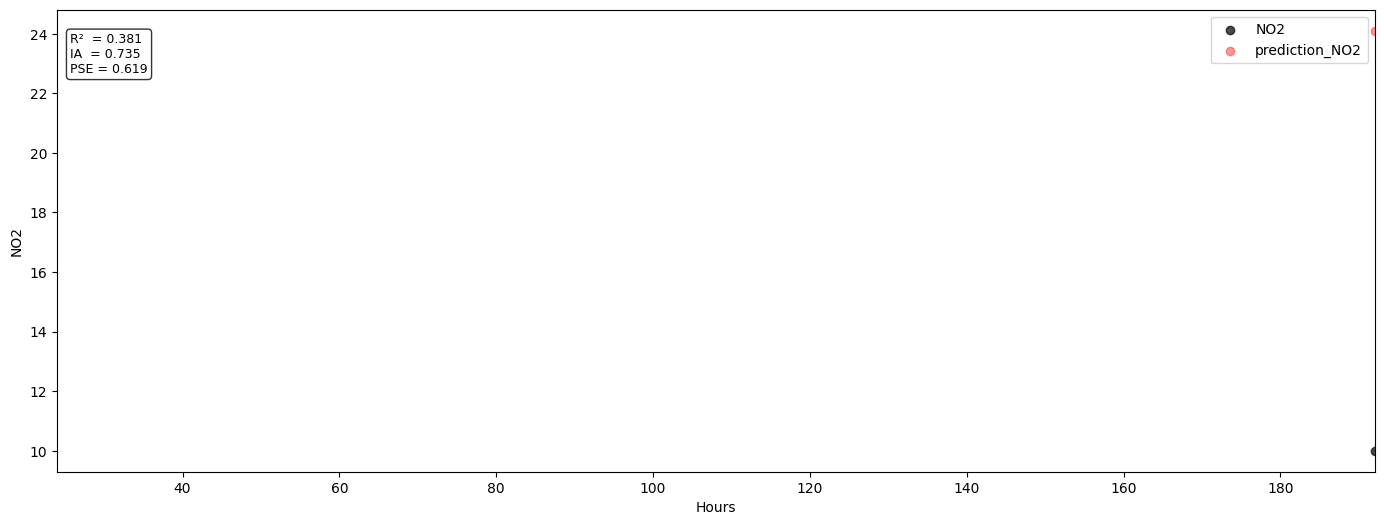

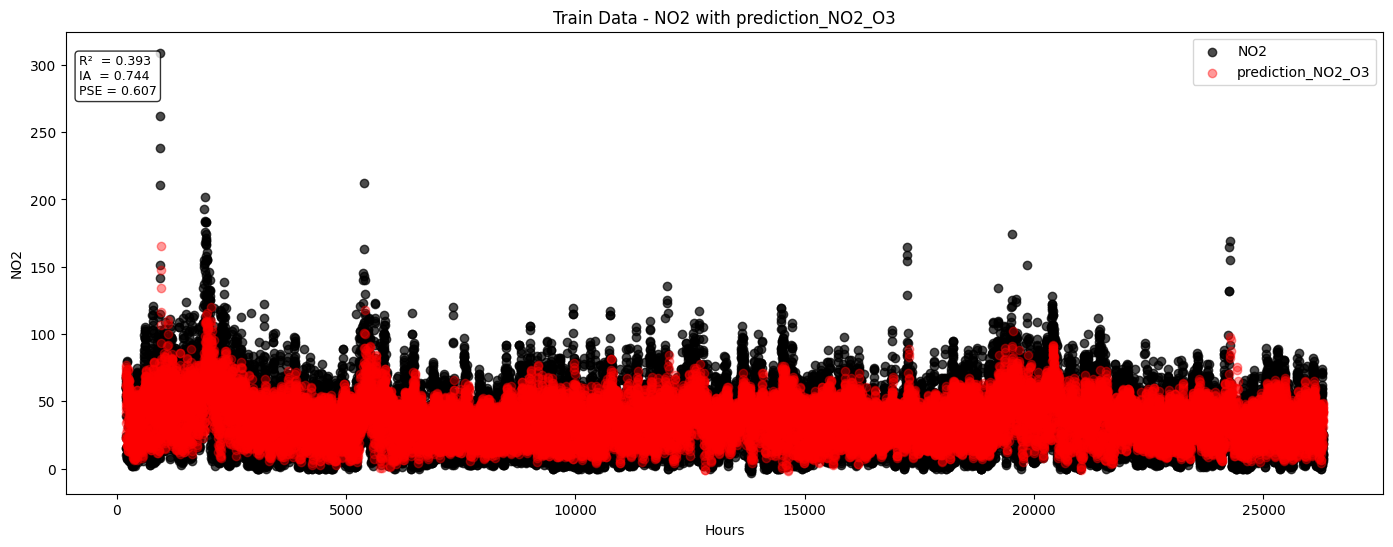

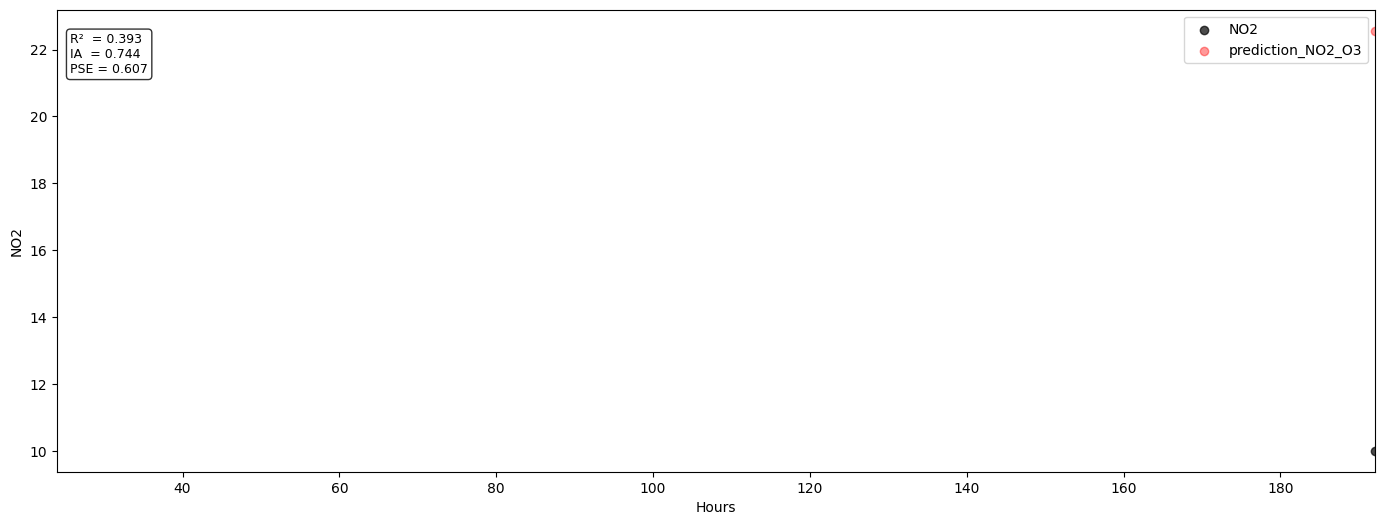

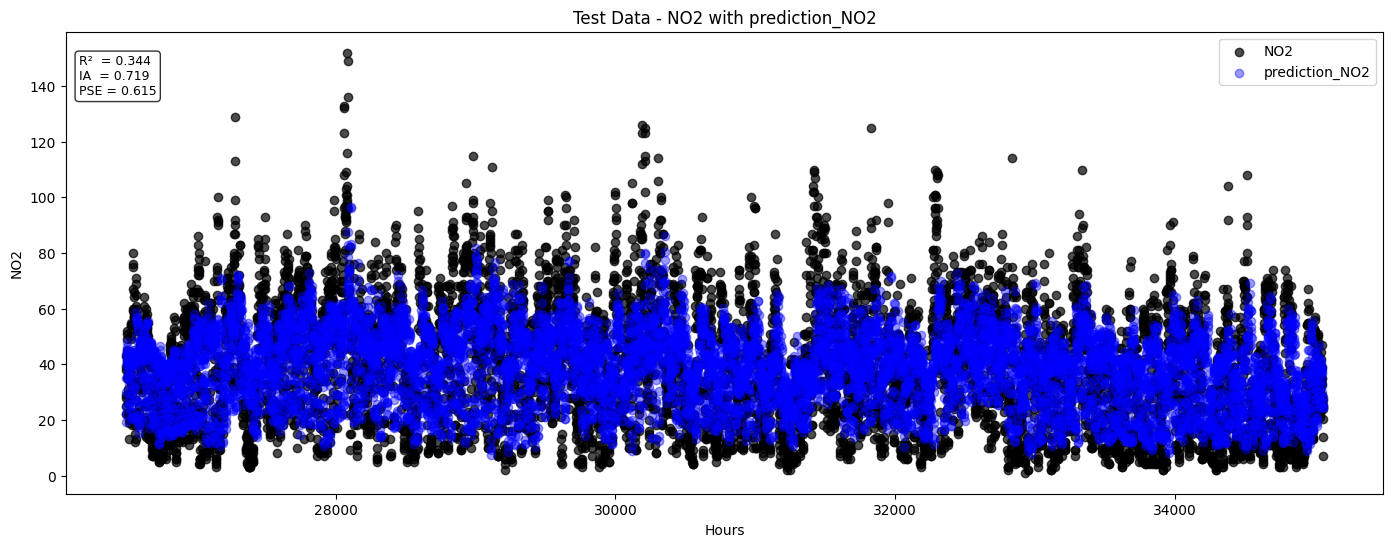

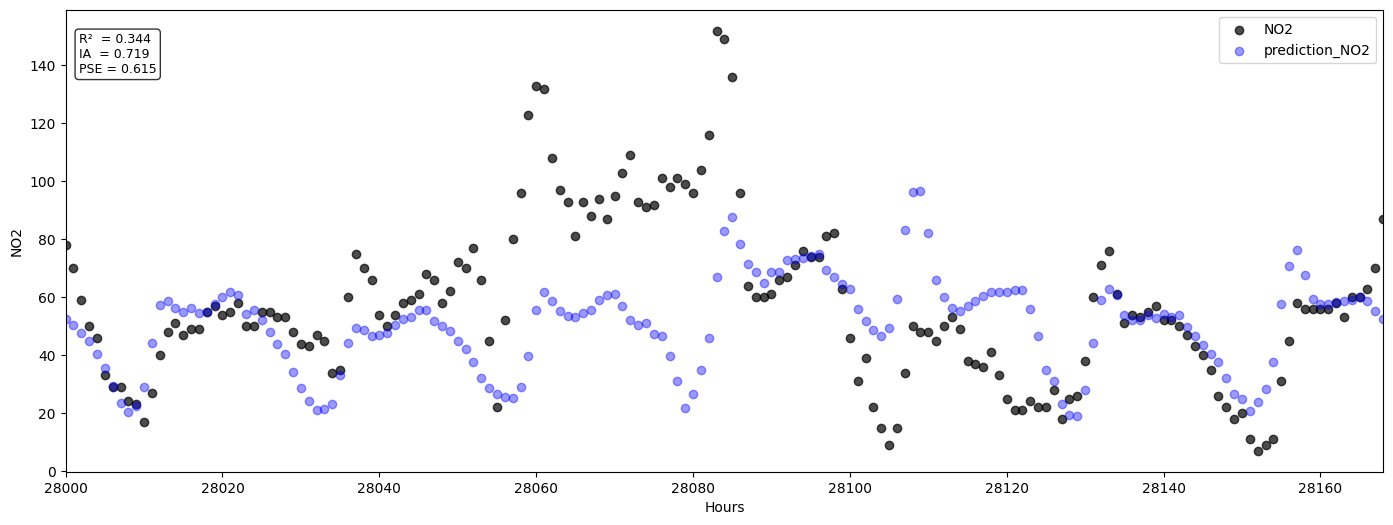

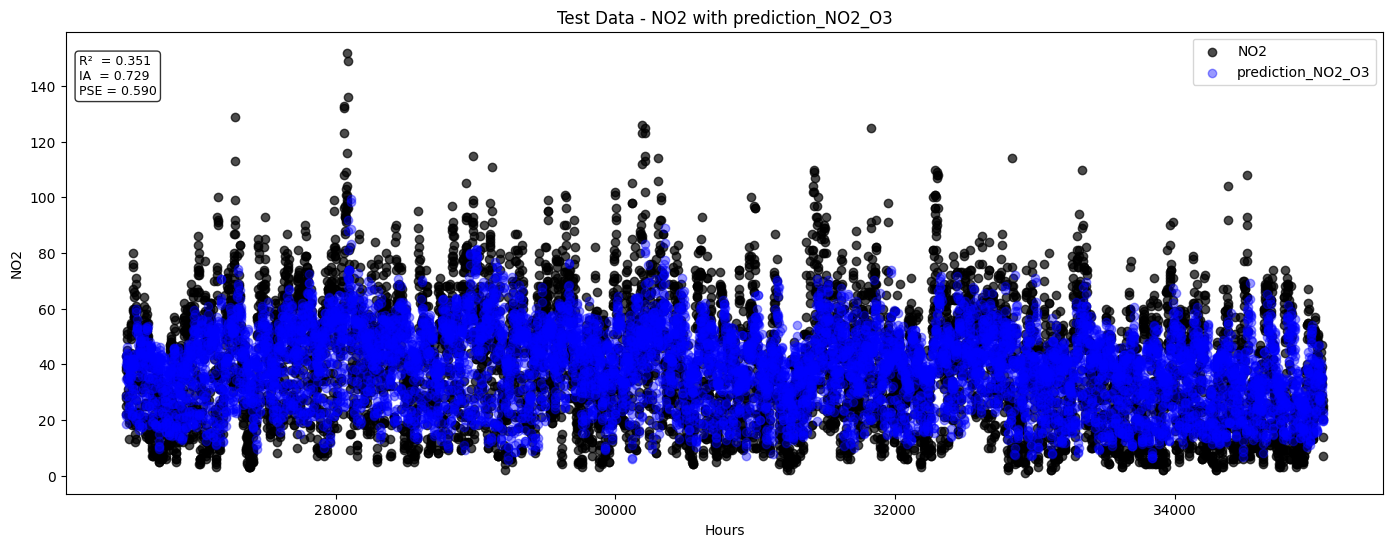

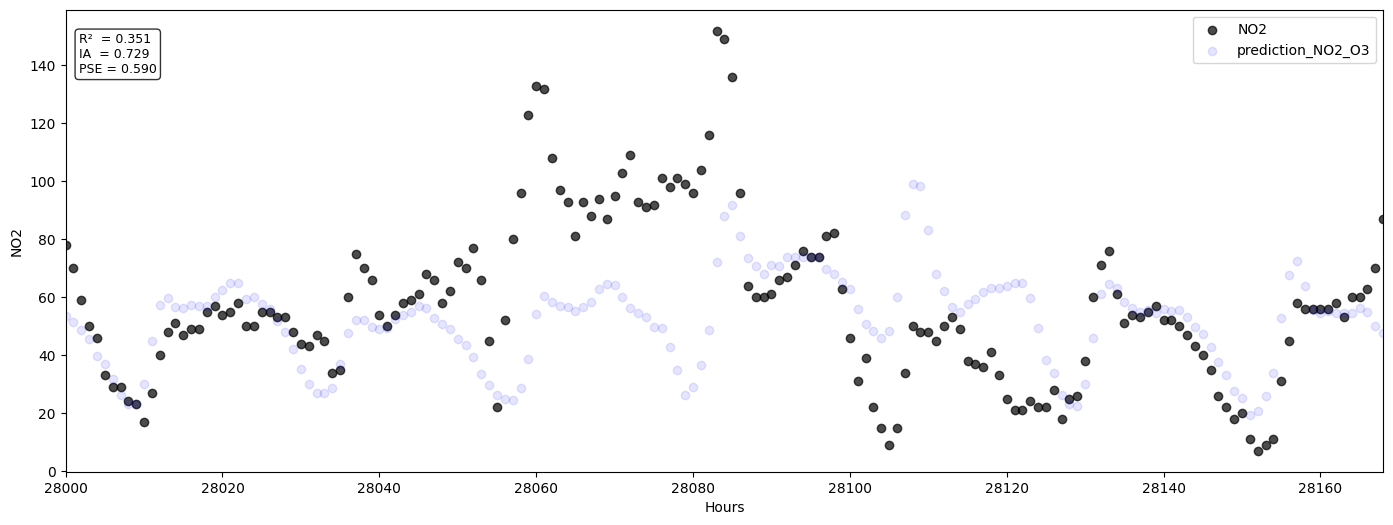

In [352]:
# ========= COMPUTE METRICS =========
# Train: NO2-only
y_train_true      = df_train_lagged["NO2"].values
y_train_pred_no2  = df_train_lagged["prediction_NO2"].values
r2_tr_no2  = calc_r_squared(y_train_pred_no2, y_train_true)
ia_tr_no2  = index_agreement(y_train_pred_no2, y_train_true)
pse_tr_no2 = calc_pse(y_train_pred_no2, y_train_true)
text_tr_no2 = (
    f"R²  = {r2_tr_no2:.3f}\n"
    f"IA  = {ia_tr_no2:.3f}\n"
    f"PSE = {pse_tr_no2:.3f}"
)

# Train: NO2+O3
y_train_pred_no2_o3 = df_train_lagged["prediction_NO2_O3"].values
r2_tr_no2_o3  = calc_r_squared(y_train_pred_no2_o3, y_train_true)
ia_tr_no2_o3  = index_agreement(y_train_pred_no2_o3, y_train_true)
pse_tr_no2_o3 = calc_pse(y_train_pred_no2_o3, y_train_true)
text_tr_no2_o3 = (
    f"R²  = {r2_tr_no2_o3:.3f}\n"
    f"IA  = {ia_tr_no2_o3:.3f}\n"
    f"PSE = {pse_tr_no2_o3:.3f}"
)

# Test: NO2-only
y_test_true      = df_test_lagged["NO2"].values
y_test_pred_no2  = df_test_lagged["prediction_NO2"].values
r2_te_no2  = calc_r_squared(y_test_pred_no2, y_test_true)
ia_te_no2  = index_agreement(y_test_pred_no2, y_test_true)
pse_te_no2 = calc_pse(y_test_pred_no2, y_test_true)
text_te_no2 = (
    f"R²  = {r2_te_no2:.3f}\n"
    f"IA  = {ia_te_no2:.3f}\n"
    f"PSE = {pse_te_no2:.3f}"
)

# Test: NO2+O3
y_test_pred_no2_o3 = df_test_lagged["prediction_NO2_O3"].values
r2_te_no2_o3  = calc_r_squared(y_test_pred_no2_o3, y_test_true)
ia_te_no2_o3  = index_agreement(y_test_pred_no2_o3, y_test_true)
pse_te_no2_o3 = calc_pse(y_test_pred_no2_o3, y_test_true)
text_te_no2_o3 = (
    f"R²  = {r2_te_no2_o3:.3f}\n"
    f"IA  = {ia_te_no2_o3:.3f}\n"
    f"PSE = {pse_te_no2_o3:.3f}"
)

# ========= PLOTTING =========

# ------- Train data with prediction_NO2 -------
plt.figure(figsize = (17, 6))
plt.scatter(df_train_lagged['hour_idx'], df_train_lagged['NO2'],
            color='black', alpha=0.7, label='NO2')
plt.scatter(df_train_lagged['hour_idx'], df_train_lagged['prediction_NO2'],
            color='red', alpha=0.4, label='prediction_NO2')
plt.xlabel('Hours')
plt.ylabel('NO2')
plt.title('Train Data - NO2 with prediction_NO2')
plt.legend(loc="upper right")

ax = plt.gca()
ax.text(
    0.01, 0.95,
    text_tr_no2,
    transform=ax.transAxes,
    va="top",
    ha="left",
    fontsize=9,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
)
plt.show()

# zoomed
xmin, xmax = 24, 192   # <- set to the range you want
mask = (df_train_lagged["hour_idx"] >= xmin) & (df_train_lagged["hour_idx"] <= xmax)
df_zoom = df_train_lagged.loc[mask]

plt.figure(figsize=(17, 6))
plt.scatter(df_zoom["hour_idx"], df_zoom["NO2"],
            color='black', alpha=0.7, label='NO2')
plt.scatter(df_zoom["hour_idx"], df_zoom['prediction_NO2'],
            color='red', alpha=0.4, label='prediction_NO2')
plt.xlim(xmin, xmax)
plt.xlabel("Hours")
plt.ylabel("NO2")
plt.legend(loc="upper right")

ax = plt.gca()
ax.text(
    0.01, 0.95,
    text_tr_no2,
    transform=ax.transAxes,
    va="top",
    ha="left",
    fontsize=9,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
)
plt.show()

# ------- Train data with prediction_NO2_O3 -------
plt.figure(figsize = (17, 6))
plt.scatter(df_train_lagged['hour_idx'], df_train_lagged['NO2'],
            color='black', alpha=0.7, label='NO2')
plt.scatter(df_train_lagged['hour_idx'], df_train_lagged['prediction_NO2_O3'],
            color='red', alpha=0.4, label='prediction_NO2_O3')
plt.xlabel('Hours')
plt.ylabel('NO2')
plt.title('Train Data - NO2 with prediction_NO2_O3')
plt.legend(loc="upper right")

ax = plt.gca()
ax.text(
    0.01, 0.95,
    text_tr_no2_o3,
    transform=ax.transAxes,
    va="top",
    ha="left",
    fontsize=9,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
)
plt.show()

# zoomed
xmin, xmax = 24, 192   # <- set to the range you want
mask = (df_train_lagged["hour_idx"] >= xmin) & (df_train_lagged["hour_idx"] <= xmax)
df_zoom = df_train_lagged.loc[mask]

plt.figure(figsize=(17, 6))
plt.scatter(df_zoom["hour_idx"], df_zoom["NO2"],
            color='black', alpha=0.7, label='NO2')
plt.scatter(df_zoom["hour_idx"], df_zoom['prediction_NO2_O3'],
            color='red', alpha=0.4, label='prediction_NO2_O3')
plt.xlim(xmin, xmax)
plt.xlabel("Hours")
plt.ylabel("NO2")
plt.legend(loc="upper right")

ax = plt.gca()
ax.text(
    0.01, 0.95,
    text_tr_no2_o3,
    transform=ax.transAxes,
    va="top",
    ha="left",
    fontsize=9,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
)
plt.show()

# ------- Test data with prediction_NO2 -------
plt.figure(figsize = (17, 6))
plt.scatter(df_test_lagged['hour_idx'], df_test_lagged['NO2'],
            color='black', alpha=0.7, label='NO2')
plt.scatter(df_test_lagged['hour_idx'], df_test_lagged['prediction_NO2'],
            color='blue', alpha=0.4, label='prediction_NO2')
plt.xlabel('Hours')
plt.ylabel('NO2')
plt.title('Test Data - NO2 with prediction_NO2')
plt.legend(loc="upper right")

ax = plt.gca()
ax.text(
    0.01, 0.95,
    text_te_no2,
    transform=ax.transAxes,
    va="top",
    ha="left",
    fontsize=9,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
)
plt.show()

# zoomed
xmin, xmax = 28000, 28168   # <- set to the range you want
mask = (df_test_lagged["hour_idx"] >= xmin) & (df_test_lagged["hour_idx"] <= xmax)
df_zoom = df_test_lagged.loc[mask]

plt.figure(figsize=(17, 6))
plt.scatter(df_zoom["hour_idx"], df_zoom["NO2"],
            color='black', alpha=0.7, label='NO2')
plt.scatter(df_zoom["hour_idx"], df_zoom['prediction_NO2'],
            color='blue', alpha=0.4, label='prediction_NO2')
plt.xlim(xmin, xmax)
plt.xlabel("Hours")
plt.ylabel("NO2")
plt.legend(loc="upper right")

ax = plt.gca()
ax.text(
    0.01, 0.95,
    text_te_no2,
    transform=ax.transAxes,
    va="top",
    ha="left",
    fontsize=9,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
)
plt.show()

# ------- Test data with prediction_NO2_O3 -------
plt.figure(figsize = (17, 6))
plt.scatter(df_test_lagged['hour_idx'], df_test_lagged['NO2'],
            color='black', alpha=0.7, label='NO2')
plt.scatter(df_test_lagged['hour_idx'], df_test_lagged['prediction_NO2_O3'],
            color='blue', alpha=0.4, label='prediction_NO2_O3')
plt.xlabel('Hours')
plt.ylabel('NO2')
plt.title('Test Data - NO2 with prediction_NO2_O3')
plt.legend(loc="upper right")

ax = plt.gca()
ax.text(
    0.01, 0.95,
    text_te_no2_o3,
    transform=ax.transAxes,
    va="top",
    ha="left",
    fontsize=9,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
)
plt.show()

# zoomed
xmin, xmax = 28000, 28168   # <- set to the range you want
mask = (df_test_lagged["hour_idx"] >= xmin) & (df_test_lagged["hour_idx"] <= xmax)
df_zoom = df_test_lagged.loc[mask]

plt.figure(figsize=(17, 6))
plt.scatter(df_zoom["hour_idx"], df_zoom["NO2"],
            color='black', alpha=0.7, label='NO2')
plt.scatter(df_zoom["hour_idx"], df_zoom['prediction_NO2_O3'],
            color='blue', alpha=0.1, label='prediction_NO2_O3')
plt.xlim(xmin, xmax)
plt.xlabel("Hours")
plt.ylabel("NO2")
plt.legend(loc="upper right")

ax = plt.gca()
ax.text(
    0.01, 0.95,
    text_te_no2_o3,
    transform=ax.transAxes,
    va="top",
    ha="left",
    fontsize=9,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
)
plt.show()



In [353]:
# === Build small result dataframes (aligned, no NaNs) ===
df_result_train_NO2        = df_train_lagged[["NO2", "prediction_NO2"]].dropna().rename(columns={"prediction_NO2":"final_prediction"})
df_result_train_NO2_O3     = df_train_lagged[["NO2", "prediction_NO2_O3"]].dropna().rename(columns={"prediction_NO2_O3":"final_prediction"})
df_result_test_NO2         = df_test_lagged[["NO2", "prediction_NO2"]].dropna().rename(columns={"prediction_NO2":"final_prediction"})
df_result_test_NO2_O3      = df_test_lagged[["NO2", "prediction_NO2_O3"]].dropna().rename(columns={"prediction_NO2_O3":"final_prediction"})

# === Helper to print metrics ===
def print_stats(title, dfres):
    r2  = calc_r_squared(dfres["final_prediction"], dfres["NO2"])
    ia  = index_agreement(dfres["final_prediction"], dfres["NO2"])
    rmse = calc_rmse(dfres["final_prediction"], dfres["NO2"])
    pse  = calc_pse(dfres["final_prediction"], dfres["NO2"])
    print("-" * 54)
    print(title)
    print(f"R squared: {r2:.4f}")
    print(f"Index of agreement: {ia:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"Proportion of systematic error: {pse:.4f}")

# === Your four cases ===
print_stats("Train data with prediction_NO2",    df_result_train_NO2)
print_stats("Train data with prediction_NO2_O3", df_result_train_NO2_O3)
print_stats("Test data with prediction_NO2",     df_result_test_NO2)
print_stats("Test data with prediction_NO2_O3",  df_result_test_NO2_O3)


------------------------------------------------------
Train data with prediction_NO2
R squared: 0.3813
Index of agreement: 0.7351
RMSE: 18.6285
Proportion of systematic error: 0.6187
------------------------------------------------------
Train data with prediction_NO2_O3
R squared: 0.3935
Index of agreement: 0.7437
RMSE: 18.4438
Proportion of systematic error: 0.6065
------------------------------------------------------
Test data with prediction_NO2
R squared: 0.3438
Index of agreement: 0.7191
RMSE: 17.4137
Proportion of systematic error: 0.6148
------------------------------------------------------
Test data with prediction_NO2_O3
R squared: 0.3508
Index of agreement: 0.7288
RMSE: 17.3204
Proportion of systematic error: 0.5896


Question:



Vary the lag length and identify the optimal value based on  evaluation metrics. Use the FFT/periodogram to guide candidate  lags.

Can you explian how including another variables in ARx model impacts on model perfromacne.

Explain how adding exogenous variables affects model performance.



Can you compare the model finl prformacne during the test period with  sine and cosine regressors based on the metrics and describe which model perform better (Use 1996, 1997, 1998, and 1999 as separate test periods and compare mean and standard deviation of them).

Compare test-period performance of ARX model with ine/cosine LR   across the separate test years 1996, 1997, 1998, and 1999. For each year, report the mean and standard deviation of your chosen metrics, and state which model performs better overall and discuss about overfitting and underfitting.
